# 1. Import

In [2]:
import glob
import argparse
import datetime
import os
from os.path import basename, dirname, join
import random
import json
from netCDF4 import Dataset
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import data_generator
from data_generator import HugoDataGenerator, DataGenerator_sod_f

import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2


random.seed(1)

idir = '/Data/preprocessing4hugo/output/'
input_dir_json = '/Data/'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dc8nzkxv because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 2. Definition model

In [7]:
def create_model():
    """ Create sequential CNN with convolutional and dense layers
    
    """
    # number of ice classes
    nbr_classes = 4  
    # size of SAR subimages
    ws = 50
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001

    model = Sequential()

    # Convolutional part
    model.add(BatchNormalization(input_shape=(ws, ws, 2)))
    model.add(Conv2D(c1, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(Conv2D(c2, (cs, cs), activation='relu'))
    model.add(Conv2D(c3, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Neural network part (hidden layers)
    model.add(Dropout(dropout_rate))
    model.add(Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))

    # Last neural layer (not hidden)
    model.add(Dense(nbr_classes, kernel_regularizer=l2(l2_rate), activation='softmax'))
    
    return model

# 3. Load Data

### 3.1 Parameters and load files

In [3]:
train_ratio = 0.7
with open(f'{idir}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)
npz_files=[]

for nc in all_nc :
    name = nc[:15]
    files = sorted(glob.glob(f'{idir}/{name}/*.npz'))
    npz_files += files
random.shuffle(npz_files)
print('Files numbers : '+ str (len(npz_files)))
train_files_number = int(len(npz_files) * train_ratio)
train_files = npz_files[:train_files_number]
valid_files = npz_files[train_files_number:]

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [ 'btemp_6_9h',
                    'btemp_6_9v',
                    'btemp_7_3h',
                    'btemp_7_3v',
                    'btemp_10_7h',
                    'btemp_10_7v',
                    'btemp_18_7h',
                    'btemp_18_7v',
                    'btemp_23_8h',
                    'btemp_23_8v',
                    'btemp_36_5h',
                    'btemp_36_5v',
                    'btemp_89_0h',
                    'btemp_89_0v'
                  ]
 
output_var_name = 'ice_type'
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape

params = {'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
          'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

Files numbers : 807257


### 3.2 processed data for model

In [4]:
training_generator = HugoDataGenerator(train_files, **params)
# training_generator = DataGenerator_sod_f(train_files, **params)


print(
    training_generator[0][0][0].shape, #sar
#     training_generator[0][0][1].shape, #amsr2
    training_generator[0][1].shape, #output
)


(50, 50, 50, 2) (50, 4)


In [5]:
list_combi = ["0_0", "83_5", "93_6", "87_6", "95_4", "95_6", "91_5", "95_3", "95_5", "83_6", "93_4", "91_3", "83_4", "91_6", "93_7", "96_6", "91_4", "91_2", "93_5", "82_3", "87_5", "97_7", "87_3", "82_5", "82_4", "83_3", "93_2", "93_3", "87_4", "91_7", "95_7", "82_2"]
vector_param = training_generator[0][1]
# print(vector_param[0:15])

# 4. Load model and trained weights

### 4.1 Load model and trained weights

In [8]:
# creation of the model 
model = create_model()

# loading the trained weights
# model.load_weights("weights.hdf5")

### 4.2 Apply CNN to SAR data

In [9]:
# dims_input = np.load(npz_files[0])[input_var_names[0]].shape
# input_ = layers.Input(shape=dims_input)

# x = layers.BatchNormalization()(input_)
# x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
# x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
# x = layers.BatchNormalization()

# model = Model(inputs=[input_], outputs=x)

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy')
model.summary()
cnn_predictions = model.fit(training_generator, epochs=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 2)        8         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0

InternalError: Graph execution error:

Detected at node 'sequential/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-9-cd47be5f73a8>", line 17, in <cell line: 17>
      cnn_predictions = model.fit(training_generator, epochs=2)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization/FusedBatchNormV3'
cuDNN launch failure : input shape ([50,2,50,50])
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]] [Op:__inference_train_function_1558]

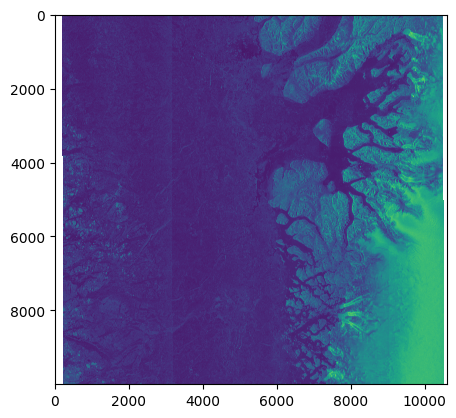

In [10]:
ifile = '/tf/data/input/20180404T205505_S1B_AMSR2_Icechart-Greenland-CentralWest.nc'
# ifile = 'tf/data/output/20180404T205505/000021.npz'
ds = Dataset(ifile, format="NETCDF4")
# data = np.load(ifile)
# sigma0_HH = data['sigma0_HH']
# sigma0_HV = data['sigma0_HV']
sigma0_HH = ds['nersc_sar_primary']
sigma0_HV = ds['nersc_sar_secondary']
plt.imshow(sigma0_HV)
plt.show()

In [11]:
# cnn_samples = []
# # subimage size
# size = 50

# rows = range(0, sigma0_HH.shape[0] - size//2, size//2)
# cols = range(0, sigma0_HH.shape[1] - size//2, size//2)
# for row in rows:
#     for col in cols:
#         hh_sub = sigma0_HH[row:row+size, col:col+size]
#         hv_sub = sigma0_HV[row:row+size, col:col+size]
#         cnn_samples.append(np.stack([hh_sub, hv_sub], axis=2))

# cnn_samples = np.array(cnn_samples)  
# ice_chart_shape = (len(rows), len(cols))

In [12]:

# creation of the model 
# model = create_model()

# loading the trained weights
# model.load_weights("weights.hdf5")

In [13]:
# cnn_predictions = model.predict(cnn_samples).reshape((ice_chart_shape[0], ice_chart_shape[1], 4))

In [14]:
# ice_class = np.argmax(cnn_predictions, axis=2)

# color_scale = ['#0064FF', '#AA28F0', '#9BD200', '#B46432']
# cmap = colors.ListedColormap(color_scale)  

# plt.imshow(ice_class, cmap=cmap)
# plt.show()